In [61]:
!pip install PyDrive

from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/GAN"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
celeba	svhn  Ver1_DCGAN_GP.ipynb


In [62]:
!ls "/content"

drive  None0000000.png	sample_data


In [63]:
%matplotlib inline

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
# Root directory for dataset
dataroot = "/content/drive/My Drive/Colab Notebooks/GAN/svhn/"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [65]:
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import dataset
import torchvision.datasets as dset
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML




datapath = '/content/drive/My Drive/Colab Notebooks/GAN/svhn'

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

trainloader, validloader, testloader = get_data_loader(datapath, 32)


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


Using downloaded and verified file: /content/drive/My Drive/Colab Notebooks/GAN/svhn/train_32x32.mat
Using downloaded and verified file: /content/drive/My Drive/Colab Notebooks/GAN/svhn/test_32x32.mat


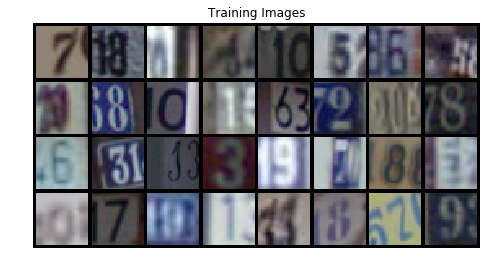

In [66]:
# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True),(1,2,0)))

# Nouvelle section

# Nouvelle section

In [0]:
def dcgan_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):

    def __init__(self, f=32):
        super(Generator, self).__init__()

        # base depth nb of feature maps
        self.f = f

        def dc_block(in_size, out_size, k=4, s=2, p=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_size, out_size, k, s, p, bias=False),
                nn.BatchNorm2d(out_size),
                nn.ReLU(True))

        self.main = nn.Sequential(
            dc_block(100, self.f * 8, 2, 1, 0),
            dc_block(self.f * 8, self.f * 4),
            dc_block(self.f * 4, self.f * 2),
            dc_block(self.f * 2, self.f),
            nn.ConvTranspose2d(self.f, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, z):
        return self.main(z)

In [69]:
from torchsummary import summary

# Create the generator
netG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(dcgan_init)

noise = torch.randn(64, nz, 1, 1, device=device)

# Print the model
print(netG)
summary(netG, (100,1,1))

Generator(
  (main): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (4): Con

In [0]:
class Discriminator(nn.Module):
    def __init__(self, f=32):
        super(Discriminator, self).__init__()

        # base nb of feature maps
        self.f = f

        def conv_block(in_size, out_size, k=4, s=2, p=1):
            return nn.Sequential(
                nn.Conv2d(in_size, out_size, k, s, p, bias=False),
                nn.InstanceNorm2d(out_size),  # No batch norm for WGAN-GP
                nn.LeakyReLU(0.2, inplace=True))

        self.main = nn.Sequential(
            nn.Conv2d(3, self.f, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            conv_block(self.f, self.f * 2),
            conv_block(self.f * 2, self.f * 4),
            conv_block(self.f * 4, self.f * 8),

            nn.Conv2d(self.f * 8, 1, 2, 1, 0, bias=False),
            # nn.Sigmoid()  # Remove Sigmoid for WGAN-GP objective
        )

    def forward(self, x):
        return self.main(x)

In [71]:
# Create the Discriminator
netD = Discriminator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netD.apply(dcgan_init)

# Print the model
print(netD)
summary(netD, (3,32,32))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace)
    )
    (5): Conv2d(256, 1, kernel_size=(2

In [0]:
from torch.autograd import grad
from torch.autograd import Variable


def c_loss(x, z):
    g = netG(z)
    c_x = netD(x).mean()
    c_g = netD(g).mean()
    l = -(c_x-c_g)
    return (l, g)

def g_loss(z):
    g = netG(z)
    l = -netD(g).mean()
    return (l, g)


# Gradient Penalty : https://arxiv.org/pdf/1704.00028.pdf 4.0
# takes in one batch of real and fake data
def gradient_penalty(D, x, g, lamda =10):
        assert x.size() == g.size()
        a = torch.rand(x.size(0), 1)
        a = a.cuda()
        a = a\
            .expand(x.size(0), x.nelement()//x.size(0))\
            .contiguous()\
            .view(x.size(0),
                3,
                32,
                32
            )
        interpolated = Variable(a*x.data + (1-a)*g.data, requires_grad=True)
        c = D(interpolated)
        gradients = grad(
            c, interpolated, grad_outputs=(
                torch.ones(c.size()).cuda()
            ),
            create_graph=True,
            retain_graph=True,
        )[0]
        return lamda * ((1-(gradients+1e-16).norm(2, dim=1))**2).mean()

In [0]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [74]:
# Training Loop
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
D_iters = 0

D_step = 2

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader, 0):
        
        
        ## Discriminator with WGAN-GP objective
        netD.zero_grad()
        
        # real
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, device=device)
        D_real = netD(real).view(-1)
        
        # fake
        sample_z = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(sample_z)
        label.fill_(fake_label)
        D_fake = netD(fake.detach()).view(-1)
        
        
        # WGAN-GP Objective loss
        penalty = gradient_penalty(netD, real, fake)
        D_loss = D_fake.mean() - D_real.mean() + penalty
        
        D_loss.backward(retain_graph=True)
        
        D_x = D_real.mean()
        D_G_z1 = D_fake.mean().item()
        optimizerD.step()
        D_iters += 1

        ## Generator
        # 
        if D_iters % D_step == 0:
          netG.zero_grad()
          label.fill_(real_label)
          D_fake = netD(fake).view(-1)

          G_loss = - D_fake.mean()
          G_loss.backward()

          D_G_z2 = D_fake.mean().item()
          optimizerG.step()
        
        
        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%4d/%4d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch + 1, num_epochs, i, len(trainloader),
                     D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[1/5][   0/2061]	Loss_D: 6.8553	Loss_G: 277.1744	D(x): -0.1317	D(G(z)): -0.1958 / -277.1744
[1/5][ 100/2061]	Loss_D: -4.6434	Loss_G: 6.9858	D(x): 7.4093	D(G(z)): -0.4420 / -6.9858
[1/5][ 200/2061]	Loss_D: -28.4276	Loss_G: 19.2485	D(x): 18.6593	D(G(z)): -14.5021 / -19.2485
[1/5][ 300/2061]	Loss_D: -61.6006	Loss_G: 35.5420	D(x): 36.3740	D(G(z)): -31.3756 / -35.5420
[1/5][ 400/2061]	Loss_D: -70.1939	Loss_G: 47.4591	D(x): 43.2841	D(G(z)): -38.2493 / -47.4591
[1/5][ 500/2061]	Loss_D: -99.9856	Loss_G: 60.3606	D(x): 54.7312	D(G(z)): -52.8120 / -60.3606
[1/5][ 600/2061]	Loss_D: -124.8496	Loss_G: 73.0508	D(x): 60.3002	D(G(z)): -73.0484 / -73.0508
[1/5][ 700/2061]	Loss_D: -153.9844	Loss_G: 84.9800	D(x): 78.4485	D(G(z)): -83.2470 / -84.9800
[1/5][ 800/2061]	Loss_D: 32.4406	Loss_G: -46.3233	D(x): 66.1546	D(G(z)): 89.5068 / 46.3233
[1/5][ 900/2061]	Loss_D: -172.6665	Loss_G: 95.6966	D(x): 95.4013	D(G(z)): -90.7092 / -95.6966
[1/5][1000/2061]	Loss_D: -62.6702	Loss_G: 73.2655

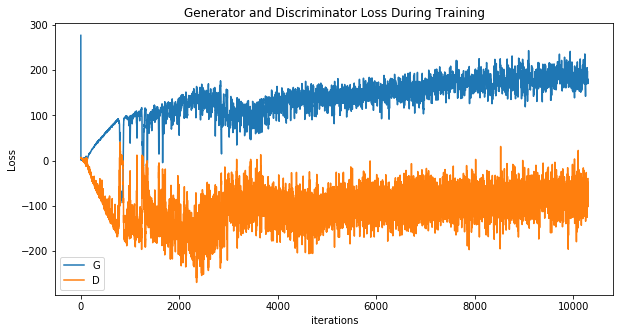

In [75]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

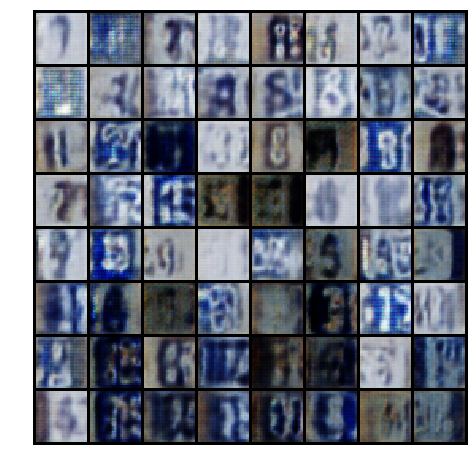

In [76]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

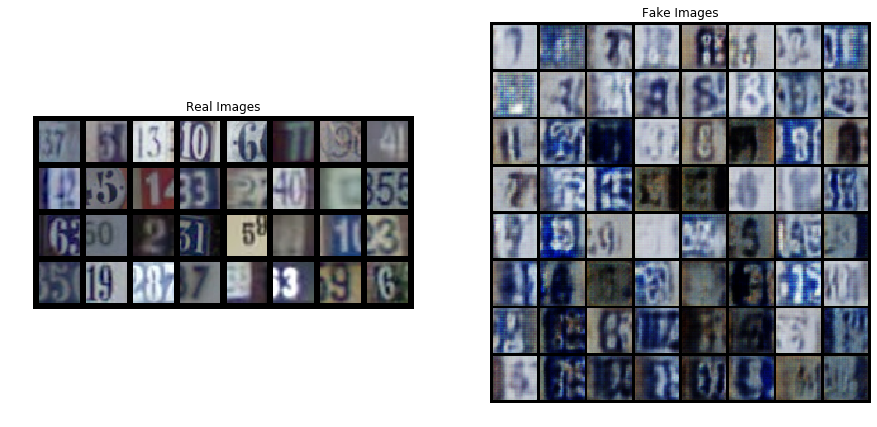

In [77]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()